In [1]:
#Cold dipole solution with grad(phi) = 0 at the coil  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import Dipole_Tools as dt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, linalg as sla
from scipy.interpolate import RectBivariateSpline, interp1d
from numba import jit, njit, prange
from matplotlib import rc
#rc('text',usetex=True)

In [3]:
#Set-up of the grid according to the traps geometry, the boundary conditions and natural constants
#Apex config
R_coil = 15.3/2  #coil radius APEX trap
dR_coil = 2.1 
R_wall = 3*R_coil #20 
H = 2*R_coil #13 

c = 2.99e10 #Speed of light
e = 1.602e-20*c #elementary charge
q = -e #electron charge
me = 9.109e-28 #electron mass

#B0 = 1 #Magnetic field B(r=0, z=0) due to the inner coil in Tesla
I = 54e3*0.1*c #Current in the inner coil of APEX Trap
T0 = 1e7*1.602e-19 #Plasma temperature (1 eV in erg)
omega = 1e6 #Rotation frequency in rad/s
N0 = 1e10 #Total Number of particles

res_r = 3000 # Radial number of grid points
res_z = 1000 # Longitudinal number of grid points

filename_load = 'LTE'
filename_save = 'LTE'

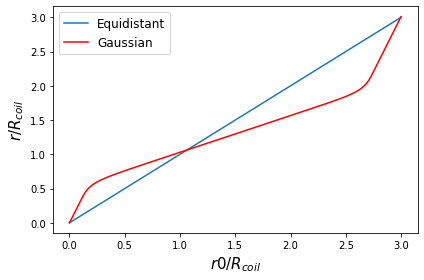

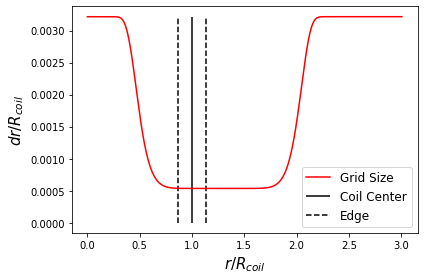

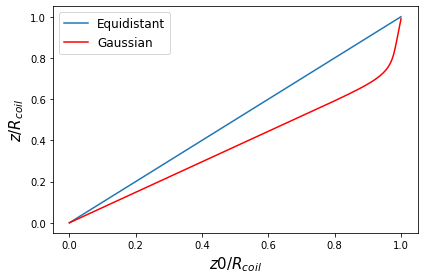

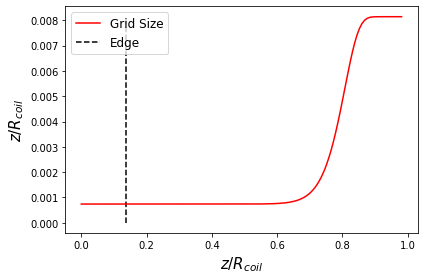

In [4]:
def spacing_r(r, dr, R_wall, R_coil, res_r):
    
    sigma_dr = (R_wall-R_coil)/2.5#Width of the gaussian
    #APEX
    dr0 = 2.68*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Matt
    #dr0 = 2.85*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    dr_min = dr0*0.2 #Minimal Distance of two grid points
    R_exp = 1.25*R_coil #Maxima of the super-gaussian = minima in grid spacing
    exp_r = 10
    
    if len(dr) == 0:
        dr = 2*[dr0+dr_min]
        r = [R_wall, R_wall-dr0]
    dr_i = 2*dr[-1] - dr[-2] #of the next grid point to calculate the corresponding spacing
    dr.append(dr0*(1-np.exp(-(r[-1]-dr[-1]-R_exp)**exp_r/(sigma_dr**exp_r)))+dr_min) #and I need the spacing
    r.append(r[-1]-dr[-1])
    
    return r, dr

def spacing_z(z, dz, R_coil, H, res_z):
    
    sigma_dz = 0.4*H
    dz0 = 3.7*H/res_z
    dz_min = 0.1*dz0
    exp_z = 20

    if len(dz) == 0:
        dz = 2*[dz0+dz_min]
        z = [H/2, H/2-dz0]
    dz_i = 2*dz[-1] - dz[-2]
    dz.append(dz0*(1-np.exp(-(z[-1]-dz[-1])**exp_z/(2*sigma_dz**exp_z)))+dz_min)
    z.append(z[-1]-dz[-1])
        
    return z, dz

r, z, dr, dz, r0, z0 = dt.grid(R_coil, R_wall, H, res_r, res_z, spacing_r, spacing_z, 0)
show = dt.check_grid(r, z, r0, z0, R_coil, dR_coil, dr, dz, res_r, res_z)

In [5]:
z_ue = abs(z-dR_coil/2) #height of the upper edge of the coil 
i_ue = np.argmin(z_ue) #index of the upper edge of the coil
i_le = 0
r_ie = abs(r-(R_coil-dR_coil/2)) #radius of the inner edge of the coil 
i_ie = np.argmin(r_ie) #index of the inner edge of the coil 
r_oe = abs(r-(R_coil+dR_coil/2)) #radius of the outer edge of the coil 
i_oe = np.argmin(r_oe) #index of the outer edge of the coil
i_coil = np.argmin(abs(r-(R_coil))) #index of the outer edge of the coil
i_bottom = np.argmin(abs(r-(r[i_oe]+r[-1])/2)) #Index of the radius in between coil and wall 
                                               #(approximatly the bottom of the potential well)
i_mid = np.argmin(abs(z))

In [6]:
mask = np.zeros((res_r, res_z))

data, col, row = dt.laplace_electrodes(r, dr, dz, mask)
A = csc_matrix((data, (col, row)), shape=(res_r*res_z, res_r*res_z))
del data, col, row 
lu = sla.splu(A) #Anna schreibt mit am heiligen Kot 

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'rz' of function 'AGM_Dipole'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Dipole_Tools_1D.py", line 357:
@njit(parallel = True)
def AGM_Dipole(itr, r, z, rz, dz, C,res_r, res_z, R):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


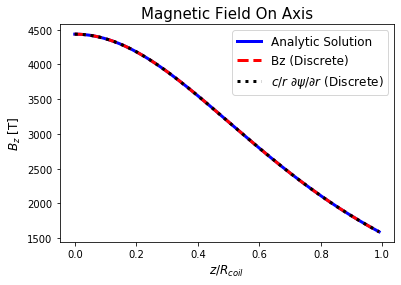

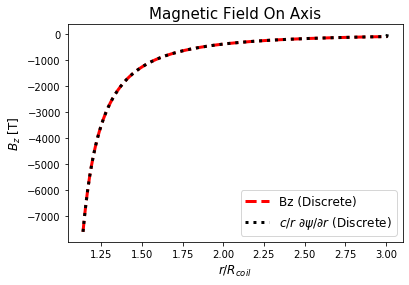

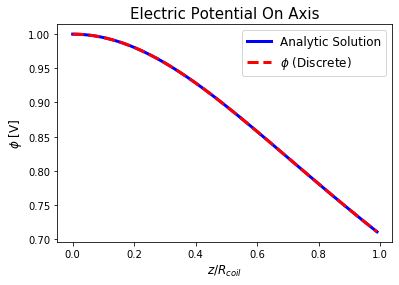

In [7]:
C = (2*I/c) #Scaling factor for Magnetic field/flux
Field_in = 0
if Field_in == 0:
    rz = np.meshgrid(z, r)
    psi, Bz, Br, phi_coil =  dt.AGM_Dipole(20, r, z, rz, dz, C, res_r, res_z, R_coil)
    Bz[0, :] = Bz[1, :]
    #np.savetxt('psi.txt', psi)
    #np.savetxt('Bz.txt', Bz)
    #np.savetxt('Br.txt', Br)
    #np.savetxt('phi_coil.txt', phi_coil)
    del  rz
elif Field_in == 1:
    psi = np.loadtxt('psi.txt')
    Bz = np.loadtxt('Bz.txt')
    Br = np.loadtxt('Br.txt')
    phi_coil = np.loadtxt('phi_coil.txt')

#psi_in, Bz_in, Br_in, dpsi_dr_in = AGM_test(4, r, z, rz, dz, C, R_coil, res_r, res_z)
dpsi_dr_dis = np.zeros((res_r, res_z))
for i in range(1, res_r-1):
    dr_i = (dr[i-1]+dr[i])*r[i]
    for j in range(res_z):
        dpsi_dr_dis[i, j] = (psi[i+1, j] - psi[i-1, j])/(dr_i)

Bz_ana = C*np.pi*R_coil**2/(z**2+R_coil**2)**(3/2)

plt.plot(z/R_coil, Bz_ana, 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, Bz[0, :], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(z/R_coil, dpsi_dr_dis[2, :], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

plt.plot(r[i_oe:]/R_coil, Bz[i_oe:, 0], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(r[i_oe:]/R_coil, dpsi_dr_dis[i_oe:, 0], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$r/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

phi_ana = 1/np.sqrt(z**2+R_coil**2)

plt.plot(z/R_coil, phi_ana/np.max(phi_ana), 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, phi_coil[0, :]/np.max(phi_coil[0, :]), 'r', label='$\phi$ (Discrete)', linewidth=3, linestyle='dashed')
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$\phi$ [V]', fontsize=12)
plt.title('Electric Potential On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

In [8]:
print(c*np.sqrt(2*me*T0)/(e*Bz_ana[0]))
print((e*Bz_ana[0])/(c*me))
print(np.sqrt(1e13*(1.602e-19)**2/(2*9.1e-31*8.8e-12)))

0.0007603383569201285
78001688275.4744
126585943.13351306


In [9]:
phi_2d = np.loadtxt('LTE2GTE_'+str(round(0.0, 2))+'potential.txt')
f_2d = np.loadtxt('LTE2GTE_'+str(round(0.0, 2))+'distribution.txt')
f_norm = f_2d[:, 0]
check = 0
for i in range(i_oe+1, res_r):
    if check == 0 and f_norm[i] > 1e-5:
        i_max = i
        check = 1
    if check == 1 and f_norm[i] <= 1e-5:     
        i_min = i
        break

mask_lte = np.zeros((res_r, res_z))
mask_lte[psi>psi[i_min, 0]] = 1
mask_lte[psi>psi[i_max, 0]] = 0
mask_lte[i_ie:i_oe, i_le:i_ue] = 0

print(r[i_max]/R_coil, r[i_min]/R_coil)

1.456357221843082 2.6039617500812877


N = 1.07e+10


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply


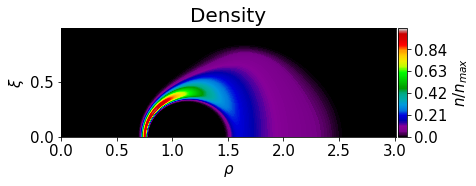

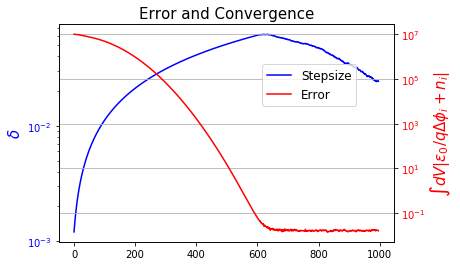

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply


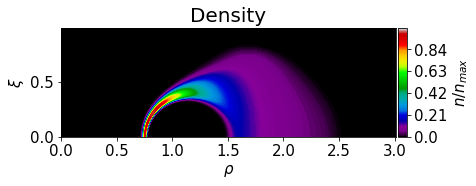

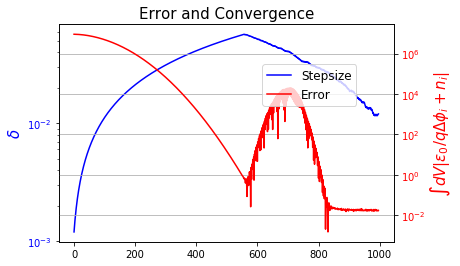

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in exp
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply


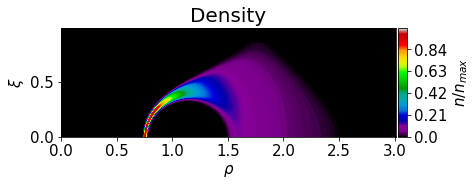

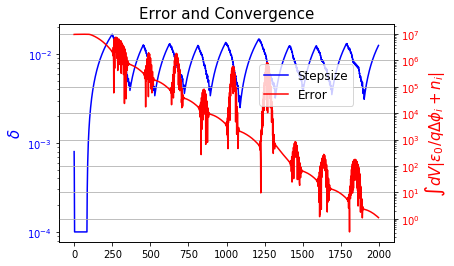

In [10]:
#filename_load = 'T_psi10'

cent = -np.transpose((me*omega**2/(2*q))*np.array(res_z*[r**2])) #Effective centrifugal potential
cent[0, :] = 0
scale = omega*I*R_coil/c**2
phi_rot = (omega/c)*psi
#T = T0*np.array([1.0, 0.5, 0.1])
T = T0*np.array([])

for i in range(len(T)):
    
    if T[i]/T0 == 1.0: 
        itr = 1000
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        print('N = %1.2e' %(N0))
        phi_tot = phi_2d + phi_rot
        phi_el = phi_2d + phi_rot
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  
        cooling = 0
        diff = 1e20 #Initialize difference between iteration, I use that as a measure of the convergence
        sum_error = 1e30
        T_i = T[i]
        delta = 0.01   #Step width for the change of the potentiall from one iteration to the next
        ddelta = 0.01*delta #Change of step width if error decreases
        delta_min = 0.01*delta #Minimum Step width
    else:
        phi_2d = np.loadtxt(filename_load+'_'+str(round(T[i]/T0, 2))+'potential.txt')
        f_2d = np.loadtxt(filename_load+'_'+str(round(T[i]/T0, 2))+'distribution.txt')
        #phi_2d = np.loadtxt(filename_load+'_'+str(round(1.0, 2))+'potential.txt')
        #f_2d = np.loadtxt(filename_load+'_'+str(round(1.0, 2))+'distribution.txt')
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        phi_tot = phi_2d + phi_rot
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  
        phi_el = phi_2d + phi_rot
        sum_error = 1e30#Error[-1]
        diff = 1e20#Diff[-1]
        if T[i]/T0 < 0.2:
        #    cooling = 1
            itr = 2000
        else:
        #    cooling = 0
            itr = 1000 
        cooling = 0
        delta = 0.01   #Step width for the change of the potentiall from one iteration to the next
        ddelta = 0.01*delta #Change of step width if error decreases
        delta_min = 0.01*delta #Minimum Step width
    Error = np.zeros((itr))
    Diff = np.zeros((itr))
    Delta = np.zeros((itr))
    T_i = T[i]
    delta = 0.001
    for m in range(itr):

        if cooling == 1 and m <= int(2*itr/3):
            T_i = (1-3*m/(2*itr))*T[i-1] + (3*m/(itr*2))*T[i]
        f0 = f  #Save last distribution and calculate new Boltzmann distribuion from old potential
        f_psi_inter = interp1d(psi[i_max:i_min, 0], f_norm[i_max:i_min]/np.exp(-q*phi_tot[i_max:i_min, 0]/T_i), kind = 'cubic', bounds_error=False, fill_value=0)
        #f_psi_inter = interp1d(psi[i_max:i_min, 0], f_norm[i_max:i_min]/np.exp(-q*phi_tot[i_max:i_min, 0]/T_psi_2d[i_max:i_min, 0]), kind = 'cubic', bounds_error=False, fill_value=0)
        F_psi = f_psi_inter(psi)
        f_2d = np.nan_to_num(mask_lte*F_psi*np.exp(-q*phi_tot/T_i))
        #f_2d = np.nan_to_num(mask_lte*F_psi*np.exp(-q*phi_tot/T_psi_2d))
        f_2d[f_2d<0] = 0
        f_2d = dt.F_norm(f_2d, F0, r, z, dr, dz, mask_lte, res_r, res_z)
        f_2d = np.nan_to_num(f_2d)
        f = f_2d.flatten()

        d2phi = A.dot(-phi)
        sum_error0 = sum_error
        sum_error = abs(dt.N_error(d2phi, f, mask_lte, r, z, dz, e, res_r, res_z))
        #print(sum_error)
        Error[m] = sum_error #Add error to list                         
        diff0 = diff #Save old difference
        diff = np.sum(abs(f-f0)) #Calculate new difference
        #print(diff)
        Diff[m] = np.sum(diff) #Add difference to list 
        Delta[m] = np.sum(delta)
        if sum_error <= sum_error0:
            phi1 = lu.solve(delta*f+(1-delta)*f0)
            phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
            delta += ddelta
        elif sum_error > sum_error0:
            phi1 = lu.solve(f0)
            phi = phi1*delta + (1-delta)*phi
            delta = np.max((delta-3*ddelta, delta_min))
        phi = np.nan_to_num(phi)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_rot
        
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi 
        
        #if sum_error <= 0.1:
        #    break

    phi_el = phi_2d + phi_rot
    n_2d = f_2d/(4*np.pi*e)
    n_2d[i_ie:i_oe, i_le:i_ue] = 0

    i_max_n = np.argmax(n_2d[:i_ie, 0])
    maxi = 1.05
    mini = 0
    psi_contour = np.zeros((res_r, res_z))
    psi_contour[psi < psi[i_max_n, 0]] = 0.01
    contours_C = np.arange(mini, maxi, (maxi-mini)/200)
    
    #mask, phi_well, depth_vac = well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, 0)

    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.contourf(r/R_coil, z/R_coil, np.transpose(n_2d/np.max(n_2d)), contours_C, cmap='nipy_spectral')
    #im_mask = ax.contour(r/R_coil, z/R_coil, np.transpose(mask), contours_mask, cmap='binary')
    #im_psi = ax.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contours_C, colors='w', linestyles='dashed')
    ax.set_xlabel(r"$\rho$", fontsize = 15)
    ax.set_ylabel(r"$\xi$", fontsize = 15)
    ax.tick_params(labelsize=15) 
    cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
    cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
    tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=15)
    cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
    ax.set_title('Density', fontsize=20)
    #plt.savefig('Force_Balance_LTE.png', dpi = 400)
    plt.show()

    fig, ax1 = plt.subplots()
    color = 'b'
    ax1.set_ylabel('$\delta$', color=color, fontsize = 15)
    ax1.plot(Delta[2:m], label='Stepsize', color = 'b')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-ax
    color = 'r'
    ax2.set_ylabel('$\int dV |\epsilon_0/q \Delta\phi_i+n_i|$', color=color, fontsize = 15)
    ax2.plot(Error[2:m], label='Error', color = 'r')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    plt.grid()
    fig.legend(loc = (0.57, 0.6), fontsize = 12)
    plt.title('Error and Convergence', fontsize = 15)
    #plt.savefig('Error_Convergence.jpg', dpi = 400)
    plt.show()     

    filename_save = 'LTE'
    save = 'y'
    #save = input('save data? y/n ')
    if save == 'y':    
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'potential.txt', phi_2d)
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'distribution.txt', f_2d)
        np.savetxt(filename_save+'_'+str(round(T[i]/T0, 2))+'potential.txt', phi_2d)
        np.savetxt(filename_save+'_'+str(round(T[i]/T0, 2))+'distribution.txt', f_2d)

    #del f0, phi, phi1